# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

ModuleNotFoundError: No module named 'google.colab'

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

## Corner and edge detection 

We'll use corner and edge detection to lower the search space in an attempt to speed thing up a bit 

In [41]:
import cv2
import numpy as np

def medianCleaner(image):#To clean images from salt and pepper noise, but preserving sharp edges
    return cv2.medianBlur(image, 3)

def unsharp_mask(image, sigma=1.0, strength=1.5, threshold=0): #Method to sharpen edges 
    """
    Apply unsharp masking to an image
    
    Args:
        image: Input image
        sigma: Gaussian blur sigma (higher = more blur)
        strength: Enhancement strength (higher = more sharpening)
        threshold: Minimum difference threshold (optional)
    """
    # Step 1: Create blurred version
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    
    # Step 2: Calculate the mask (difference)
    mask = cv2.subtract(image, blurred)
    
    # Step 3: Optional threshold
    if threshold > 0:
        mask = np.where(np.abs(mask) < threshold, 0, mask)
    
    # Step 4: Add mask back to original
    sharpened = cv2.add(image, cv2.multiply(mask, strength))
    
    return sharpened


def find_rectangular_regions(image):
    # Step 1: Edge detection (missing in original code)
    edges = cv2.Canny(image, 50, 150)
    
    # Step 2: Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rectangles = []
    for contour in contours:
        # Approximate contour to polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Look for 4-sided polygons (potential books)
        if len(approx) == 4:
            rectangles.append(approx)
    
            cv2.polylines(image, [approx], isClosed=True, color=(0, 255, 0), thickness=2)

    return image, rectangles

def segment_by_shelf_lines(image):
    # Detect horizontal lines (shelf edges)
    edges = cv2.Canny(image, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, 
                           minLineLength=image.shape[1]//3, maxLineGap=10)
    
    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2-y1, x2-x1) * 180 / np.pi
        if abs(angle) < 10:  # Nearly horizontal
            horizontal_lines.append(((x1, y1), (x2, y2)))
    
    # Sort by y-coordinate to get shelf levels
    horizontal_lines.sort(key=lambda line: (line[0][1] + line[1][1]) / 2)
    
    # Create regions between shelf lines
    shelf_regions = []
    for i in range(len(horizontal_lines) - 1):
        y_top = horizontal_lines[i][0][1]
        y_bottom = horizontal_lines[i+1][0][1]
        shelf_regions.append((0, y_top, image.shape[1], y_bottom - y_top))
    
    return shelf_regions

def detect_book_candidates(scene_path, min_area=1000, epsilon_ratio=0.02, angle_threshold=20):
    """
    Detects rectangular contours (likely books) in a shelf scene image using edge detection.

    Args:
        scene_path (str): Path to the scene image.
        min_area (int): Minimum area of contour to be considered.
        epsilon_ratio (float): Ratio for contour approximation.
        angle_threshold (float): Allowed deviation from 90-degree angles.

    Returns:
        image_with_boxes (np.ndarray): Image with drawn bounding boxes.
        boxes (list): List of 4-point boxes [(x1,y1), ..., (x4,y4)].
    """
    # Load and preprocess
    image = cv2.imread(scene_path)
    image = medianCleaner(image)
    image = unsharp_mask(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue

        # Polygonal approximation
        epsilon = epsilon_ratio * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        print(approx)
        # We're looking for 4-point shapes
        #pts = approx.reshape(4, 2)

        # Sort corners for consistency
        #pts = sort_corners(pts)

        # Angle check
        boxes.append(approx)

        # Draw box
        cv2.polylines(image, [approx], isClosed=True, color=(0, 255, 0), thickness=2)

    return image, boxes

def sort_corners(pts):
    """Sort corners in top-left, top-right, bottom-right, bottom-left order."""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left

    return rect.astype(int)

def angle_between(v1, v2):
    """Compute angle (in degrees) between two vectors."""
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def is_rectangular(pts, tolerance):
    """Check if all angles between adjacent sides are ~90 degrees within a tolerance."""
    for i in range(4):
        v1 = pts[(i+1)%4] - pts[i]
        v2 = pts[(i+2)%4] - pts[(i+1)%4]
        angle = angle_between(v1, v2)
        if not (90 - tolerance <= angle <= 90 + tolerance):
            return False
    return True


92 candidate book(s) detected.
ciao


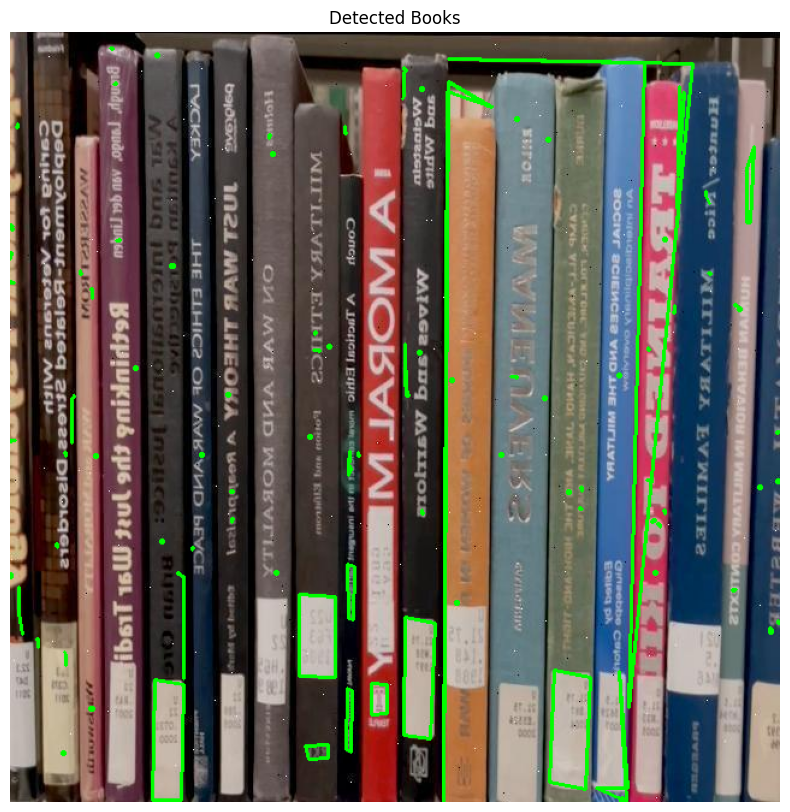

In [40]:
import matplotlib.pyplot as plt 

scene_path = "dataset/dataset/scenes/scene_0.jpg"

image = cv2.imread(scene_path)


image_with_boxes, boxes = find_rectangular_regions(image)

print(f"{len(boxes)} candidate book(s) detected.")
#for i, box in enumerate(boxes):
#    print(f"Book {i}: corners={box.tolist()}")
print("ciao")
image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Detected Books')
plt.show()


(-0.5, 639.5, 639.5, -0.5)

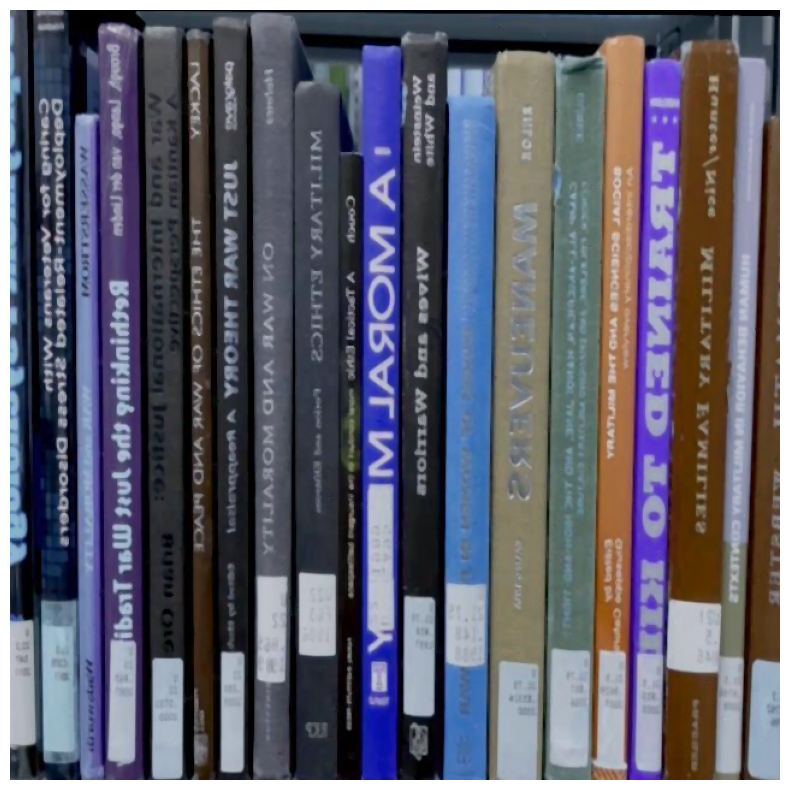

In [ ]:
cleaned = medianCleaner(image)
plt.figure(figsize=(10, 10))
plt.imshow(cleaned)
plt.axis('off')


(-0.5, 639.5, 639.5, -0.5)

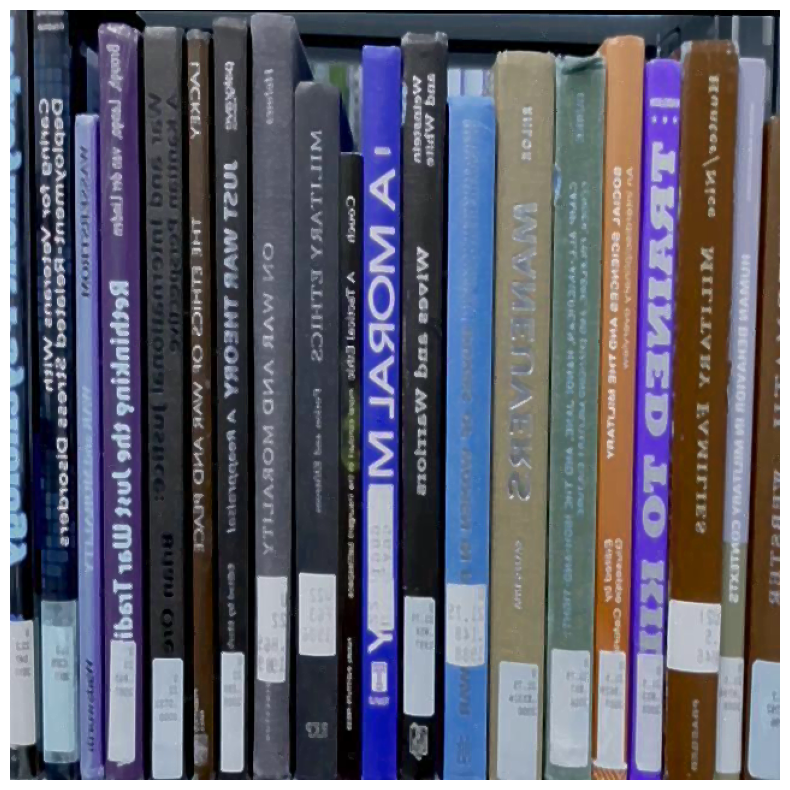

In [ ]:
sharped = unsharp_mask((cleaned))
plt.figure(figsize=(10, 10))
plt.imshow(sharped)
plt.axis('off')


Image loaded: (640, 640, 3)
Total lines detected: 143
Horizontal lines found: 2
Shelf regions created: 1
Region 1: 30 vertical boundaries found

SHELF LINE DETECTION RESULTS
Horizontal shelf lines detected: 2
Shelf regions identified: 1
Vertical book boundaries detected: 30

Shelf Regions:
  Shelf 1: x=0, y=28, width=640, height=612


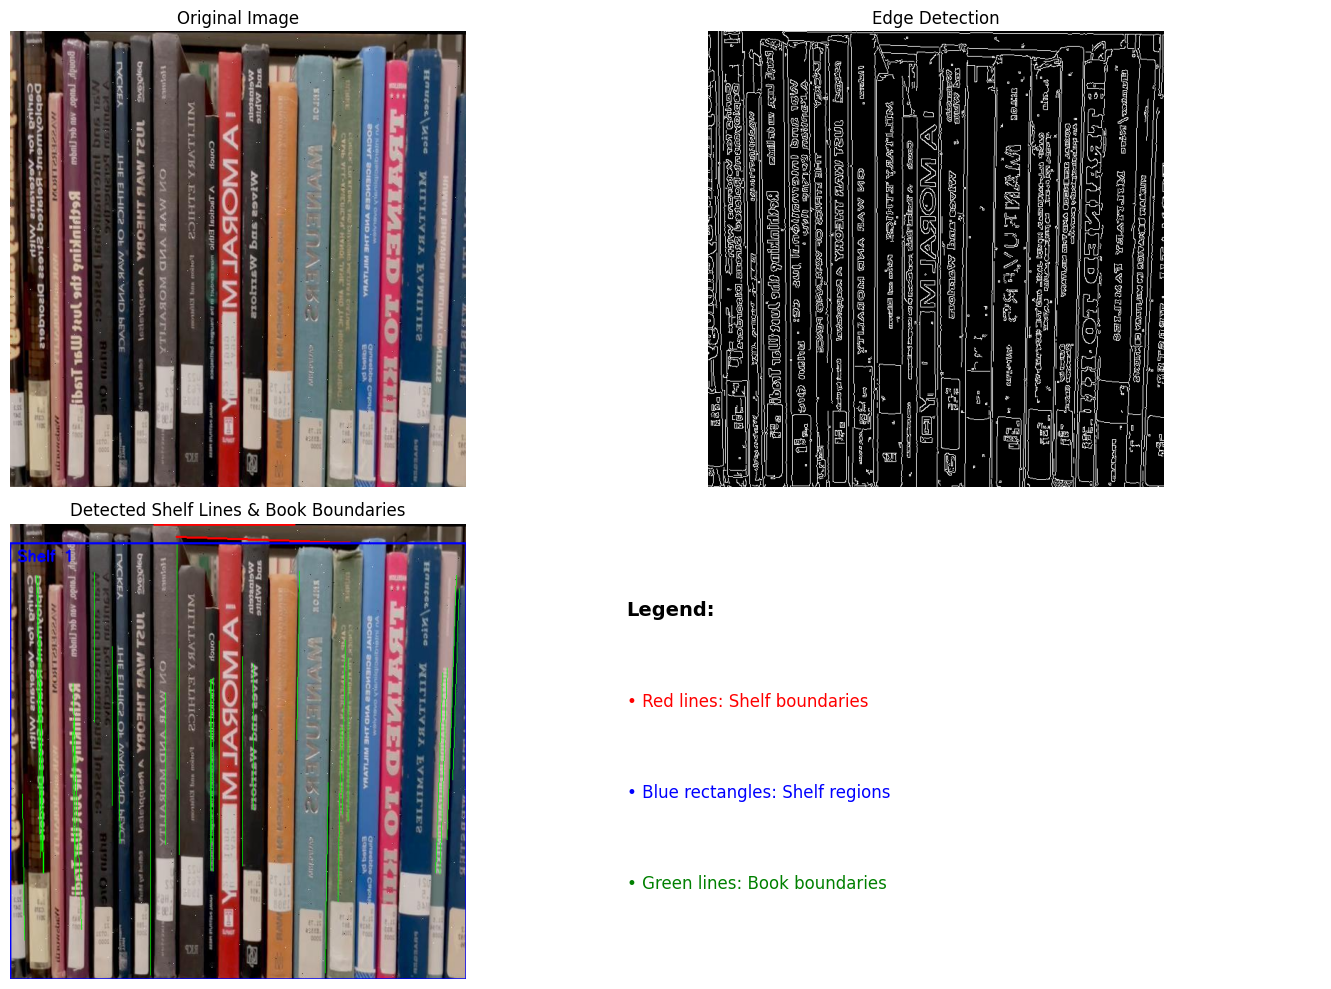


Result saved as 'shelf_segmentation_result.jpg'


In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shelf_lines(image):
    """
    Detect horizontal shelf lines using Hough Line Transform
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(
        edges, 
        rho=1,                    # Distance resolution in pixels
        theta=np.pi/180,          # Angle resolution in radians
        threshold=100,            # Minimum votes
        minLineLength=gray.shape[1]//4,  # Minimum line length
        maxLineGap=20             # Maximum gap between line segments
    )
    
    return lines, edges

def filter_horizontal_lines(lines, angle_tolerance=15):
    """
    Filter lines to keep only horizontal ones
    """
    if lines is None:
        return []
    
    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate angle
        if x2 - x1 != 0:
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        else:
            angle = 90  # Vertical line
        
        # Keep only nearly horizontal lines
        if abs(angle) < angle_tolerance or abs(angle - 180) < angle_tolerance:
            # Store as (y_coordinate, line_data) for sorting
            avg_y = (y1 + y2) / 2
            horizontal_lines.append((avg_y, line[0]))
    
    # Sort by y-coordinate (top to bottom)
    horizontal_lines.sort(key=lambda x: x[0])
    
    return [line_data for _, line_data in horizontal_lines]

def create_shelf_regions(horizontal_lines, image_shape):
    """
    Create shelf regions between detected horizontal lines
    """
    height, width = image_shape[:2]
    shelf_regions = []
    
    if len(horizontal_lines) == 0:
        # No lines detected, return entire image as one region
        return [(0, 0, width, height)]
    
    # Add top region (above first line)
    first_line_y = horizontal_lines[0][1]  # y1 of first line
    if first_line_y > 50:  # Only if there's substantial space
        shelf_regions.append((0, 0, width, first_line_y))
    
    # Add regions between consecutive lines
    for i in range(len(horizontal_lines) - 1):
        y_top = horizontal_lines[i][3]      # y2 of current line
        y_bottom = horizontal_lines[i+1][1] # y1 of next line
        
        # Only add if there's substantial space between lines
        if y_bottom - y_top > 30:
            shelf_regions.append((0, y_top, width, y_bottom - y_top))
    
    # Add bottom region (below last line)
    last_line_y = horizontal_lines[-1][3]  # y2 of last line
    if height - last_line_y > 50:  # Only if there's substantial space
        shelf_regions.append((0, last_line_y, width, height - last_line_y))
    
    return shelf_regions

def detect_vertical_boundaries_in_region(image, region):
    """
    Detect vertical boundaries (book edges) within a shelf region
    """
    x, y, w, h = region
    roi = image[y:y+h, x:x+w]
    
    # Convert to grayscale if needed
    if len(roi.shape) == 3:
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray_roi = roi
    
    # Edge detection focused on vertical edges
    edges = cv2.Canny(gray_roi, 30, 100)
    
    # Detect vertical lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=h//3,  # At least 1/3 of region height
        maxLineGap=10
    )
    
    vertical_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate angle
            if x2 - x1 != 0:
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            else:
                angle = 90
            
            # Keep only nearly vertical lines
            if abs(angle - 90) < 20 or abs(angle + 90) < 20:
                # Convert back to full image coordinates
                avg_x = (x1 + x2) / 2 + x
                vertical_lines.append((avg_x, [x1+x, y1+y, x2+x, y2+y]))
    
    # Sort by x-coordinate
    vertical_lines.sort(key=lambda x: x[0])
    
    return [line_data for _, line_data in vertical_lines]

def segment_by_shelf_lines(image_path):
    """
    Main function to segment image by shelf lines and book boundaries
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    print(f"Image loaded: {image.shape}")
    
    # Step 1: Detect horizontal shelf lines
    lines, edges = detect_shelf_lines(image)
    print(f"Total lines detected: {len(lines) if lines is not None else 0}")
    
    # Step 2: Filter for horizontal lines
    horizontal_lines = filter_horizontal_lines(lines)
    print(f"Horizontal lines found: {len(horizontal_lines)}")
    
    # Step 3: Create shelf regions
    shelf_regions = create_shelf_regions(horizontal_lines, image.shape)
    print(f"Shelf regions created: {len(shelf_regions)}")
    
    # Step 4: Detect vertical boundaries in each region
    all_vertical_lines = []
    for i, region in enumerate(shelf_regions):
        vertical_lines = detect_vertical_boundaries_in_region(image, region)
        all_vertical_lines.extend(vertical_lines)
        print(f"Region {i+1}: {len(vertical_lines)} vertical boundaries found")
    
    # Step 5: Create visualization
    result_image = image.copy()
    
    # Draw horizontal lines (shelf boundaries) in red
    for line in horizontal_lines:
        x1, y1, x2, y2 = line
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Draw shelf regions as rectangles in blue
    for i, (x, y, w, h) in enumerate(shelf_regions):
        cv2.rectangle(result_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # Add region label
        cv2.putText(result_image, f'Shelf {i+1}', (x+10, y+25), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    # Draw vertical lines (book boundaries) in green
    for line in all_vertical_lines:
        x1, y1, x2, y2 = line
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    return result_image, shelf_regions, horizontal_lines, all_vertical_lines

def main():
    # Test the shelf line detection
    scene_path = "dataset/dataset/scenes/scene_0.jpg"
    
    try:
        # Run the segmentation
        result_image, shelf_regions, horizontal_lines, vertical_lines = segment_by_shelf_lines(scene_path)
        
        # Print results
        print("\n" + "="*50)
        print("SHELF LINE DETECTION RESULTS")
        print("="*50)
        print(f"Horizontal shelf lines detected: {len(horizontal_lines)}")
        print(f"Shelf regions identified: {len(shelf_regions)}")
        print(f"Vertical book boundaries detected: {len(vertical_lines)}")
        
        print("\nShelf Regions:")
        for i, (x, y, w, h) in enumerate(shelf_regions):
            print(f"  Shelf {i+1}: x={x}, y={y}, width={w}, height={h}")
        
        # Display results
        plt.figure(figsize=(15, 10))
        
        # Original image
        plt.subplot(2, 2, 1)
        original = cv2.imread(scene_path)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        # Edge detection result
        _, edges = detect_shelf_lines(original)
        plt.subplot(2, 2, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')
        
        # Result with detected lines and regions
        plt.subplot(2, 2, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title('Detected Shelf Lines & Book Boundaries')
        plt.axis('off')
        
        # Legend
        plt.subplot(2, 2, 4)
        plt.text(0.1, 0.8, 'Legend:', fontsize=14, fontweight='bold')
        plt.text(0.1, 0.6, '• Red lines: Shelf boundaries', fontsize=12, color='red')
        plt.text(0.1, 0.4, '• Blue rectangles: Shelf regions', fontsize=12, color='blue')
        plt.text(0.1, 0.2, '• Green lines: Book boundaries', fontsize=12, color='green')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save result
        cv2.imwrite('shelf_segmentation_result.jpg', result_image)
        print("\nResult saved as 'shelf_segmentation_result.jpg'")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()